# DeOldify using OpenVINO

DeOldify is an open-source deep learning project, that uses generative adversarial networks (GANs) to colorize and restore old black and white images and videos. The project is built using PyTorch and utilizes a deep neural network architecture to analyze and add color to grayscale images and videos.  More details about its realization can be found in original model [repository](https://github.com/jantic/DeOldify).

This tutorial demonstrates how to convert and run the pytorch model for DeOldify with OpenVino.

There are currently three models available: one to produce stable color results on images, one to produce artistic colors on an image and one to convert a video (More details on this is available on the original [repo link](https://github.com/jantic/DeOldify).

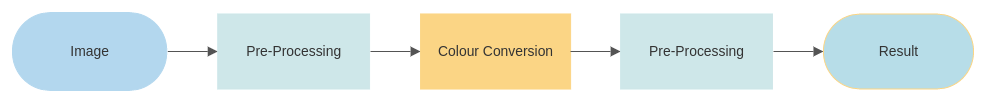

## **Validate Pytorch model**

## **Prerequisites**

In [1]:
from pathlib import Path
import sys
sys.path.append("../utils")
from notebook_utils import download_file

## Clone the repo

In [2]:
# Clone DeOldify repo
if not Path('DeOldify').exists():
    !git clone https://github.com/jantic/DeOldify.git
%cd DeOldify

/home/deimos/Desktop/Gsoc/openvino_notebooks/notebooks/269-DeOldify/DeOldify


## Install requirements

In [ ]:
!pip install -r requirements.txt
!pip install onnxruntime

## Imports

In [3]:
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.CPU)
from deoldify.visualize import *
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

import fastai
torch.backends.cudnn.benchmark=True

NumExpr defaulting to 8 threads.


## Helper Function

In [4]:
def subfolder_check(color_source_path: str):
    """
    Checks if the specified directory exists and creates the directory if it doesn't exist.

    Parameters:
        color_source_path (str): The path of the directory that needs to be checked and created.

    Returns:
        None
    """
    if not Path(color_source_path).exists():
        os.mkdir(color_source_path)

## Download pre-trained model weights and run inference

We take user input in the cell below to decide if we want to generate results for an image or a video and also to check whether the model is expected to generate artistic output or not.

In [11]:
image = input("Enter True if you want to colorize an image and False to colorize a video")
if image == "True":
    artistic = input("Enter True to generate artistic results and False to get Stable result ")

Enter True if you want to colorize an image and False to colorize a videoTrue
Enter True to generate artistic results and False to get Stable result False


Based on what we decide, either the pre-trained **ColorizeArtistic_gen.pth** is downloaded using the download_file function provided exclusively by OpenVino Toolkit or **ColorizeStable_gen.pth** is downloaded and for videos, we download the **ColorizeVideo_gen.pth**.

ColorizeArtistic_gen.pth : The model uses a resnet34 backbone on a UNet with an emphasis on depth of layers on the decoder side. This model was trained with 5 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px. 

ColorizeStable_gen.pth : This model uses a resnet101 backbone on a UNet with an emphasis on width of layers on the decoder side. This model was trained with 3 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px.

ColorizeVideo_gen.pth : The model is the same as "stable" in terms of architecture, but differs in training. It's trained at 192px, using only the initial generator/critic pretrain/GAN NoGAN training.

In [6]:
if image == "True":
    if artistic == "True":
        if not Path('models/ColorizeArtistic_gen.pth').exists():
            MODEL_LINK = "https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth"
            MODEL_DIR = Path("models/")
            download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)
    else:
        if not Path('models/ColorizeStable_gen.pth').exists():
            !wget https://www.dropbox.com/s/axsd2g85uyixaho/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth
else:
    if not Path('models/ColorizeVideo_gen.pth').exists():
        !wget https://data.deepai.org/deoldify/ColorizeVideo_gen.pth -O ./models/ColorizeVideo_gen.pth

Here is a black and white image of a beautiful women and using DeOldify, we will colorize it. But first lets download the image and store it under the test_images directory which is present in our cloned repository for DeOldify. This photo is taken from this [website](https://photo-works.net/how-to-make-picture-black-and-white.php) which converts a color photo to black and white.

In [22]:
import yt_dlp as youtube_dl
def test_case(image) -> None:
    """
    Download a test image or video to be used for testing a computer vision algorithm.

    Parameters:
        image: If True, download a test image. Otherwise, download a test video.

    Returns:
        None
    """
    if image == 'True':
        !wget https://photo-works.net/images/tutorial/how-ot-make-picture-black-and-white-after.jpg -O ./test_images/image.png
    else:
        subfolder_check('video')
        subfolder_check('video/source')
#         !wget https://twitter.com/silentmoviegifs/status/1116751583386034176/ -O ./video/source/vid.mp4
#         !wget -c -O ./video/source/vid.mp4 "https://twitter.com/silentmoviegifs/status/1116751583386034176
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
            'outtmpl': str(Path("video/source/vid.mp4")),
            'retries': 30,
            'fragment-retries': 30
        }
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            ydl.download(["https://www.facebook.com/100042153756500/videos/165148923091758"])

test_case(image)

/bin/bash: -O: command not found


Down in the cells is the part where we load the model and get the colored image or video.

In [8]:
if image == "True":
    colorizer = get_image_colorizer(artistic = artistic)
else:
    colorizer = get_video_colorizer()

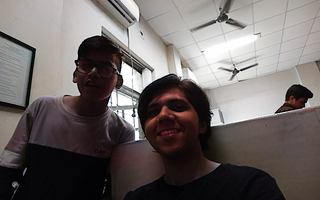

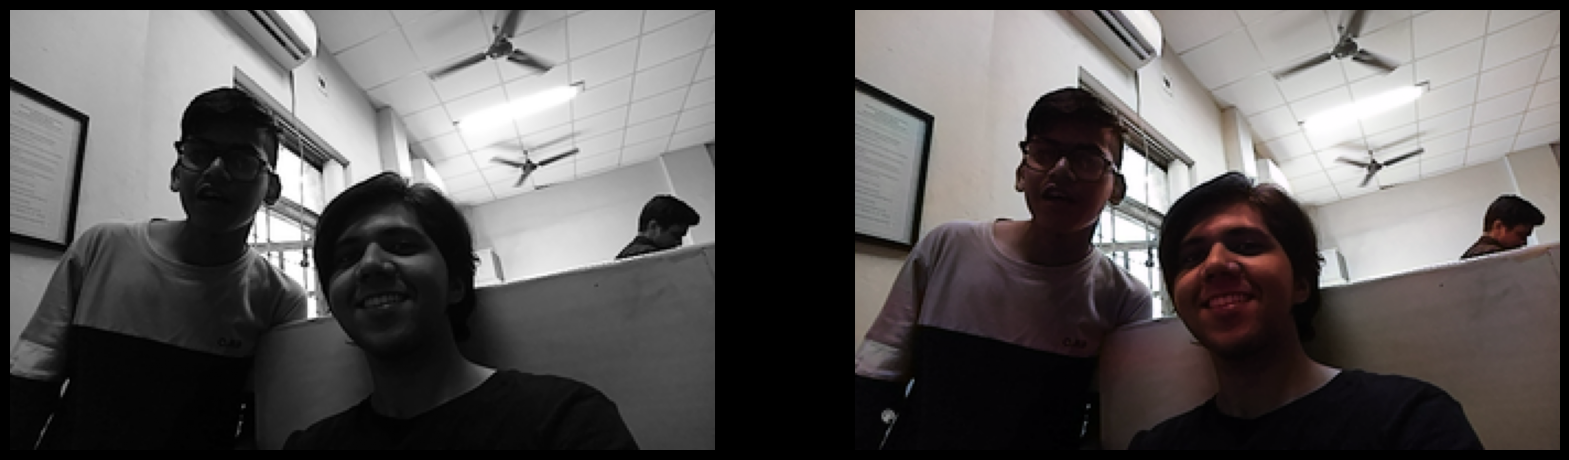

In [23]:
if image == "True":
    #NOTE:  Max is 45 with 11GB video cards. 35 is a good default
    render_factor=35
    #NOTE:  Make source_url None to just read from file at ./test_images/[file_name] directly without modification
#     source_url='https://scontent.xx.fbcdn.net/v/t1.15752-9/333957255_741938823980386_4154367814708985503_n.png?stp=dst-png_s320x320&_nc_cat=103&ccb=1-7&_nc_sid=aee45a&_nc_ohc=hbiOguA621kAX-VmwKA&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&oh=03_AdTJIuq9UX72-n0fVxYS89jCcZ9uYC45AHEBkUfcNnLVNw&oe=642991EB'
    source_url = None
    source_path = 'test_images/image.png'
    result_path = None

    if source_url is not None:
        result_path = colorizer.plot_transformed_image_from_url(url=source_url, path=source_path, render_factor=render_factor, compare=True)
    else:
        result_path = colorizer.plot_transformed_image(path=source_path, render_factor=render_factor, compare=True)

    show_image_in_notebook(result_path)
else:
    #NOTE:  Max is 44 with 11GB video cards.  21 is a good default
    render_factor=21
    #NOTE:  Make source_url None to just read from file at ./video/source/[file_name] directly without modification
#     source_url='https://twitter.com/silentmoviegifs/status/1116751583386034176'
    source_url = None
    file_name = 'vid'
    file_name_ext = file_name + '.mp4'
    result_path = None

    if source_url is not None:
        result_path = colorizer.colorize_from_url(source_url, file_name_ext, render_factor=render_factor)
    else:
        result_path = colorizer.colorize_from_file_name(file_name_ext, render_factor=render_factor)

    show_video_in_notebook(result_path)

## Convert Pytorch model into onnx format

Before we start converting the pytorch model into onnx format and later into OpenVino IR format, lets define some variables to improve code redability and minimize the number of if statements when switching models.

In [24]:
if image == "True":
    if artistic == 'True':
        wt_name="ColorizeArtistic_gen"
        onnx_path = "models/ColorizeArtistic_deoldify.onnx"
        onnx_name = "ColorizeArtistic_deoldify.onnx"
        xml_name = 'models/ColorizeArtistic_deoldify.xml'
        bin_name = 'models/ColorizeArtistic_deoldify.bin'
    else:
        wt_name="ColorizeStable_gen"
        onnx_path = "models/ColorizeStable_deoldify.onnx"
        onnx_name = "ColorizeStable_deoldify.onnx"
        xml_name ='models/ColorizeStable_deoldify.xml'
        bin_name ='models/ColorizeStable_deoldify.bin'
else:
    wt_name="ColorizeVideo_gen"
    onnx_path = "models/ColorizeVideo_deoldify.onnx"
    onnx_name = "ColorizeVideo_deoldify.onnx"
    xml_name = 'models/ColorizeVideo_deoldify.xml'
    bin_name = 'models/ColorizeVideo_deoldify.bin'

Below we convert the pytorch model into onnx format.
First we load the pytorch model. We need to remove the spectral normalizations after loading the model as this is an unsupported operator in ONNX and not doing so raises an error while exporting. We define a 192x192 image input size. 

In [ ]:
import onnx
import onnxruntime
import numpy as np
import torch
from typing import Union
import deoldify.generators

INPUT_SIZE = 576 # use 192 or 96 if cell fails to run  

def remove_all_spectral_norm(item: Union[torch.nn.Module, torch.nn.ModuleList, torch.nn.Sequential]) -> None:
    """
    Recursively removes spectral normalization from all modules in a PyTorch module.

    This function recursively traverses the input PyTorch module and its submodules, and removes spectral normalization from any module that has it. Spectral normalization is a technique used in deep learning to stabilize the training of generative models. However, in some cases it may be desirable to remove spectral normalization after the model has been trained.

    Parameters:
        item (Union[torch.nn.Module, torch.nn.ModuleList, torch.nn.Sequential]): The PyTorch module to remove spectral normalization from.

    Returns:
        None
    """
    if isinstance(item, torch.nn.Module):
        try:
            torch.nn.utils.remove_spectral_norm(item)
        except Exception:
            pass
        for child in item.children():
            remove_all_spectral_norm(child)

    if isinstance(item, torch.nn.ModuleList):
        for module in item:
            remove_all_spectral_norm(module)

    if isinstance(item, torch.nn.Sequential):
        modules = item.children()
        for module in modules:
            remove_all_spectral_norm(module)


def export_to_onnx_and_test(check: bool = False) -> None:
    """
    Exports the DeOldify network as an ONNX model and tests it with a random input tensor.

    This function loads the DeOldify network from disk, sets an example input tensor to the model for exporting and testing,
    exports the model as ONNX format, and tests the exported model with a random input tensor.
    The function also removes spectral normalization from the model, as 'mv' operation is not supported by torch.onnx.export.

    Parameters:
        check (bool): A flag indicating whether to check the exported ONNX model with onnxruntime.

    Returns:
        None
    """

    print("> Load the DeOldify network")
    if image == "True":
        if artistic == "True":
            torch_model = deoldify.generators.gen_inference_deep(root_folder=Path("./"), weights_name=wt_name).model
        else:
            torch_model = deoldify.generators.gen_inference_wide(root_folder=Path("./"), weights_name=wt_name).model
    else:
        torch_model = deoldify.generators.gen_inference_wide(root_folder=Path("./"), weights_name=wt_name).model
    torch_model.eval()

    print("> Set example input to the model for exporting and for testing")
    example_input_t = torch.rand(1, 3, INPUT_SIZE, INPUT_SIZE)
    torch_output_t = torch_model(example_input_t)

    print("> Export the model as ONNX format")
    remove_all_spectral_norm(torch_model)  # 'mv' operation not supported by torch.onnx.export
    torch.onnx.export(torch_model, example_input_t, onnx_path, export_params=True, opset_version=9,
                      do_constant_folding=False, input_names=["input"], output_names=["output"])

export_to_onnx_and_test()

> Load the DeOldify network
> Set example input to the model for exporting and for testing
> Export the model as ONNX format


/home/deimos/Desktop/Gsoc/openvino_notebooks/notebooks/269-DeOldify/DeOldify/deoldify/unet.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:


## Convert onnx model into openvino Ir format

Although the OpenVINO runtime directly supports ONNX models, it may be advantageous to convert them to IR format in order to make use of the OpenVINO optimisation tools and capabilities. To convert a model using OpenVINO Model Optimizer, use the mo.convert model Python function. Instances of the OpenVINO Model class are returned by the function, ready for usage in the Python interface but also capable of being serialised to the OpenVINO IR format for later execution.

In [7]:
from openvino.tools import mo
from openvino.runtime import serialize

model = mo.convert_model(onnx_path)
# serialize model for saving IR
serialize(model, xml_name)

## Run inference from Openvino IR model

Next we set up the environment for deploying an OpenVINO optimized model on a CPU device and obtain information about the model input and output layers. Our process typically begins with preprocessing, then uses OpenVINO model inference and results post-processing to provide a colourized output.

Model input is in accordance with shape [1, 3, 192, 192] in N, C, H, W format, where

N - number of images in batch (batch size)

C - image channels

H - image height

W - image width

In [17]:
from openvino.runtime import Core
import numpy as np
from PIL import Image
import torch
import openvino.runtime as ov
core = Core()
# read converted model
model = core.read_model(xml_name)
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')
input_layer = compiled_model.input(0)
N, C, H, W = input_layer.shape
output_layer = compiled_model.output(0)
print('Model Input and Output Info')
print(f"- input shape: {input_layer.shape}")
print(f"- input precision: {input_layer.element_type}")
print(f"- output shape: {output_layer.shape}")
print(f"- output precision: {output_layer.element_type}")

Model Input and Output Info
- input shape: [1,3,192,192]
- input precision: <Type: 'float32'>
- output shape: [1,3,192,192]
- output precision: <Type: 'float32'>


## Image Processing - PreProcessing + PostProcessing

The pre_processing function takes an image in the form of a NumPy array as input, resizes it to a specific size using cv2.resize, converts it to a float tensor with pixel values in the range [0, 1], and normalizes pixel values using mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]. The final output of the function is a float tensor after preprocessing.

The post_processing function takes the output of a computer vision model in the form of a NumPy array as input, and post-processes it to obtain a coloured image of the same size as that of the input image. The function first normalizes the pixel values using cv2.normalize, scales the pixel values by 255, transposes the dimensions of the array, reverses the order of the channels, and converts the pixel values to unsigned 8-bit integers. The function then resizes the image to the original size of the input image and converts it to RGB format. Finally, the function returns the postprocessed image as a NumPy array.

In [25]:
import cv2
from matplotlib import pyplot as plt

def pre_processing(img: np.ndarray, W: int, H: int):
    """
    Preprocess image according to DeOldify input requirements converts preprocessed image to tensor format and changes data layout from HWC to CHW.. 
    Takes image in np.array format, resizes it to specific size using cv2.resize.
    Also converts image in np.array format with unit8 data in [0, 255] range to torch.Tensor object with float data in [0, 1] range
    Normalizes pixel values using mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225].
    
    Parameters:
      img (np.ndarray): image for preprocessing
      W : Image width that the OpenVino IR model expects
      H : Image height that the OpenVino IR model expects
      
    Returns:
      final_input (torch.Tensor): float tensor after preprocessing
      
    Note:
    This function assumes that the input image is in BGR format with pixel values in the range [0, 255].  
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    np_data = cv2.resize(img,(W, H)).astype(np.float32) / 255
    np_data -= np.array([0.485, 0.456, 0.406])
    np_data /= np.array([0.229, 0.224, 0.225])
    final_input = np.expand_dims(np_data.transpose((2, 0, 1)), 0).astype(np.float32)
    return final_input

def post_processing(colour_data: np.ndarray, imshow_size: Tuple[int, int]):
    """
    Postprocesses the output of a computer vision model to obtain a coloured image of the same size as that of input image.
    Major postprocessing steps involves normalization , scaling and resizing.

    Parameters:
        colour_data (np.ndarray): The output of the computer vision model.

    Returns:
        np.ndarray: The postprocessed image as a NumPy array.
    """
    colour_data = np.squeeze(colour_data)
    updated_colour_data = (cv2.normalize(colour_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).transpose(1, 2, 0)[:, :, ::-1] * 255).astype(np.uint8)
    final_colour_data = cv2.resize(updated_colour_data, imshow_size)
    final_img = cv2.cvtColor(final_colour_data, cv2.COLOR_BGR2RGB)
    return final_img

The cell given below are for loading inference on an image. Do not use this to colourise a video.

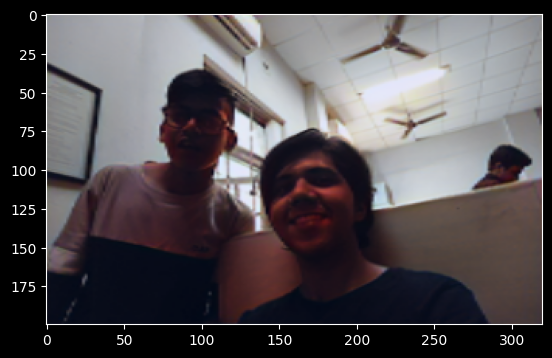

In [26]:
image_filename = 'test_images/image.png'
img = cv2.imread(image_filename)
(h_orig, w_orig) = img.shape[:2]
imshow_size = (w_orig, h_orig)
input_img = pre_processing(img , W, H)
result = compiled_model([input_img])[output_layer]
coloured_img = post_processing(result[0], imshow_size)
plt.imshow(coloured_img)
plt.show()

## Video Processing - PreProcessing + PostProcessing

In the module below, we colorise a video by breaking it down into frames and then feeding those frames as input to the DeOldify IR model. To do so, we first create a directory called bwframes which is done in the function call. Still we check if a directory called bwframes is correctly created or not. Next, we create a directory called colorframes inside the video directory to store the colorised frames. We then build the video back from the colorised frames and save it in the results directory inside the video folder.

In [8]:
from openvino.inference_engine import IECore
from matplotlib import pyplot as plt
import numpy as np

ie = IECore()

model_xml = xml_name
model_bin = bin_name

net = ie.read_network(model=model_xml, weights=model_bin)

input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

exec_net = ie.load_network(network=net, device_name='CPU')

In [9]:
def preprocess_video_frame(input_image: np.ndarray, W: int, H: int):
    """
    Preprocessing a vdeo frame  in accordance with DeOldify input specifications turns it to tensor format and switches the data layout from HWC to CHW.
    Uses cv2.resize to resize a picture in np.array format to a particular size.
    Also converts images in torch format with unit8 data in the [0, 255] range in np.array format.
    Tensor object having float values between [0, 1]
    Uses mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225] to normalise pixel values.

    Parameters:
        input_image (np.ndarray): An array of shape (height, width, channels) representing a video frame.
        W (int): Image width that the OpenVino IR model expects
        H (int): Image height that the OpenVino IR model expects
      
    Returns:
        input_image (np.ndarray): A preprocessed video frame of shape (1, 3, W, H) ready to be fed into a deep learning model.

    """
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
    input_image = cv2.resize(input_image, (W, H)).astype(np.float32) / 255
    input_image -= np.array([0.485, 0.456, 0.406])
    input_image /= np.array([0.229, 0.224, 0.225])
    input_image = np.expand_dims(input_image.transpose((2, 0, 1)), 0).astype(np.float32)
    input_image = input_image.reshape((1, 3, W, H)) 
    return input_image
def postprocess_video_frame(output: np.ndarray, shape, output_blob):
    """
    Postprocesses the output of a deep learning model for a video frame to produce colourised output.

    Paameters:
        output (np.ndarray): An array representing the output of a deep learning model.
        shape (tuple): A tuple representing the shape of the original video frame before preprocessing.
        output_blob (str): A string representing the output layer name of the deep learning model.

    Returns:
        np.ndarray: A postprocessed video frame of the original shape.

    """
    output_image = np.squeeze(output[output_blob][0])
    output_image = (cv2.normalize(output_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).transpose(1, 2, 0)[:, :, ::-1] * 255).astype(np.uint8)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    output_image = cv2.resize(output_image, shape)
    return output_image

In [11]:
import os
import re

def folder_check(folder_pth: str, folder_name: str):
    """
    Checks if a specific directory exists in the 'video' folder.
    If the directory doesn't exist, creates it.
    If the directory already exists, clears its contents by removing all the '.jpg' files in the directory.

    Returns:
        None
    """
    if not Path(folder_pth).exists():
        %cd video
        os.mkdir(folder_name)
    else:
        %cd video
    for f in os.listdir(folder_name):
        if re.search('.*?\.jpg', f):
            os.remove(os.path.join(folder_name, f))
    %cd ..
    
file_name = 'vid'
file_name_ext = file_name + '.mp4'
workfolder = Path('./video')
source_folder = workfolder / "source"
source_path = source_folder / file_name_ext
colorizer._extract_raw_frames(Path(source_path))

subfolder_check('video/bwframes/')
bwframes_folder = 'video/bwframes/'+file_name
color_source_path = "video/colorframes/"+file_name
folder_check('video/colorframes/', 'colorframes')
subfolder_check(color_source_path)

for img in progress_bar(os.listdir(bwframes_folder)):
    img_path = bwframes_folder +'/'+ img

    if os.path.isfile(str(img_path)):
        read_frame = cv2.imread(img_path)
        shape = (read_frame.shape[1], read_frame.shape[0])
        input_frame = preprocess_video_frame(read_frame)
        output = exec_net.infer(inputs={input_blob: input_frame})
        color_image = postprocess_video_frame(output, shape, output_blob)
        cv2.imwrite(str(color_source_path+"/"+img), color_image)
result_path = colorizer._build_video(Path(source_path))
show_video_in_notebook(result_path)

<>:19: DeprecationWarning: invalid escape sequence \.
<>:19: DeprecationWarning: invalid escape sequence \.
/tmp/ipykernel_27716/4012333170.py:19: DeprecationWarning: invalid escape sequence \.
  if re.search('.*?\.jpg', f):


/home/deimos/Desktop/Gsoc/openvino_notebooks/notebooks/269-DeOldify/DeOldify/video
/home/deimos/Desktop/Gsoc/openvino_notebooks/notebooks/269-DeOldify/DeOldify


Video created here: video/result/vid.mp4


Output file #0 does not contain any stream


'/home/deimos/Desktop/Gsoc/openvino_notebooks/notebooks/269-DeOldify/DeOldify'